## Initialisation

In [ ]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

In [ ]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [ ]:
dynamic_data_code = 'cdk46_ccle_dynamic_features_v3'
drug_code = 'gdsc-2-Palbociclib'
match_rules_data_code = 'cdk_model_match_rules'
folder_name = "CDK46-combined-model-training"
exp_id = "cdk46_v3" # experiment id, fgfr4_v1, cdk46_v1
normalised = True
fixed_random_seed = 42  # -1 for no seed, NOT IN USE
save_figure = False
save_data = True
show_figure = False

In [ ]:
# load in dynamic features data 
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_data_code}-true-Unnamed: 0'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {dynamic_feature_data.shape} Label Shape {dynamic_label_data.shape}')

# load in ccle static gene expression data
loading_code = f'ccle-{drug_code}-LN_IC50'
feature_data, label_data = data_link.get_data_using_code(loading_code)
print(f'Data loaded for code {loading_code} Feature Shape {feature_data.shape} Label Shape {label_data.shape}')

match_rules = data_link.get_data_from_code(match_rules_data_code)

In [ ]:
from toolkit import *

In [ ]:
all_models = ['SVR', 'RandomForestRegressor', 'XGBRegressor', 'MLPRegressor', 'KNeighborsRegressor', 'ElasticNet']

if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

In [ ]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

In [ ]:
combined_feature_data = pd.concat([new_feature_data, dynamic_feature_data], axis=1)
combined_label_data = new_label_data

In [ ]:
combined_feature_data

In [ ]:
def normalise_data(data): 
    data = (data - data.mean()) / data.std()
    return data

def pipeline_func(X_train, y_train, rng, model_used, normalised=False, **kwargs):
    # impute missing values by first quantile first 
    # normalise X_train 
    if normalised:
        X_train = normalise_data(X_train)
    X_train, _ = impute_by_first_quantile(X_train, y_train)
    k = X_train.shape[1]
    if k > 500: 
        k = 500 # limit the number of features to 500
    selected_features, scores = f_regression_select(X_train, y_train, k)
    model = get_model_from_string(model_used, **kwargs)
    selected_features, X_selected = select_preset_features(X_train, y_train, selected_features)
    # print(f'{rng} {model_used}')
    model.fit(X_selected, y_train)
    return {'model': model,
            'filter_selected_features': selected_features,
            'filter_scores': scores}


def eval_func(X_test, y_test, pipeline_components=None, normalised=False, save_model=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'model': pipeline_components['model']}

def eval_func_best(X_test, y_test, pipeline_components=None, normalised=False, **kwargs):
    if normalised:
        X_test = (X_test - X_test.mean()) / X_test.std()
    X_test, _ = impute_by_first_quantile(X_test, y_test)
    selected_features, X_selected = select_preset_features(X_test, y_test, pipeline_components['filter_selected_features'])
    y_pred = pipeline_components['model'].predict(X_selected)
    # assess performance by pearson correlation
    corr, p_vals = pearsonr(y_test, y_pred)
    feat_imp = (pipeline_components['filter_selected_features'], pipeline_components['filter_scores'])
    return {'model_performance': corr, 'p_vals': p_vals, 'feature_importance': feat_imp, 'y_test': y_test, 'y_pred': y_pred}

## Analysis

In [ ]:
import pickle
exp_id = 'cdk46_v4'
experiments = ['control_dynamic',
               'specie_genes', 'specie_genes_dynamic',
               'select_gene_dynamic']


model_used = "RandomForestRegressor"

df_list_total = []
for exp in experiments:
    df_list = []
    df = pd.read_pickle(f'{file_save_path}{exp_id}_{model_used}_{exp}.pkl')
    print(f'Loaded {model_used} for {exp}')
    df_list.append(df)

    # join all the dataframes
    df_all = pd.concat(df_list, axis=0)
    df_all['experiment'] = exp
    df_list_total.append(df_all)

total_df = pd.concat(df_list_total, axis=0)
total_df

Loaded RandomForestRegressor for control_dynamic
Loaded RandomForestRegressor for specie_genes
Loaded RandomForestRegressor for specie_genes_dynamic
Loaded RandomForestRegressor for select_gene_dynamic


,rng,condition,model_performance,p_vals,feature_importance,model,experiment
0,0,RandomForestRegressor,0.404697,1.476658e-03,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
1,1,RandomForestRegressor,0.398128,1.791080e-03,"([INSR_auc, INSR_median, INSR_tmax, INSR_max, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
2,2,RandomForestRegressor,0.470806,1.677678e-04,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
3,3,RandomForestRegressor,0.572727,2.137378e-06,"([INSR_auc, INSR_median, INSR_max, INSR_tmin, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
4,4,RandomForestRegressor,0.331200,1.039727e-02,"([INSR_auc, INSR_median, INSR_tfc, INSR_max, I...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
...,...,...,...,...,...,...,...
95,95,RandomForestRegressor,0.392404,2.112544e-03,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
96,96,RandomForestRegressor,0.508030,3.999714e-05,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
97,97,RandomForestRegressor,0.546582,7.514893e-06,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
98,98,RandomForestRegressor,0.594493,6.887507e-07,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic


In [ ]:
model_experiments = ['control_dynamic', 'specie_genes_dynamic', 'control_ccle', 'select_gene_dynamic', 'combined']
# for each model, create a dataframe with the feature importance of all features 

all_new_feat_imp = []
for index, row in total_df.iterrows():
    model = row['model']
    # print(model, row['condition'], row['rng'], row['experiment'])
    importances = model.feature_importances_.tolist()
    feature_names = row['feature_importance'][0]
    # make index a repeat of index over the number of features
    feat_imp = (feature_names, importances)
    all_new_feat_imp.append(feat_imp)
    
total_df.insert(4, 'tree_feature_importance', all_new_feat_imp)
    

In [ ]:
total_df

,rng,condition,model_performance,p_vals,tree_feature_importance,feature_importance,model,experiment
0,0,RandomForestRegressor,0.404697,1.476658e-03,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
1,1,RandomForestRegressor,0.398128,1.791080e-03,"([INSR_auc, INSR_median, INSR_tmax, INSR_max, ...","([INSR_auc, INSR_median, INSR_tmax, INSR_max, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
2,2,RandomForestRegressor,0.470806,1.677678e-04,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
3,3,RandomForestRegressor,0.572727,2.137378e-06,"([INSR_auc, INSR_median, INSR_max, INSR_tmin, ...","([INSR_auc, INSR_median, INSR_max, INSR_tmin, ...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
4,4,RandomForestRegressor,0.331200,1.039727e-02,"([INSR_auc, INSR_median, INSR_tfc, INSR_max, I...","([INSR_auc, INSR_median, INSR_tfc, INSR_max, I...","(DecisionTreeRegressor(max_features=1.0, rando...",control_dynamic
...,...,...,...,...,...,...,...,...
95,95,RandomForestRegressor,0.392404,2.112544e-03,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
96,96,RandomForestRegressor,0.508030,3.999714e-05,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
97,97,RandomForestRegressor,0.546582,7.514893e-06,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic
98,98,RandomForestRegressor,0.594493,6.887507e-07,"([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","([INSR_auc, INSR_median, INSR_tfc, INSR_tmax, ...","(DecisionTreeRegressor(max_features=1.0, rando...",select_gene_dynamic


In [ ]:
powerkit = Powerkit(new_feature_data, new_label_data)
# rename the 'experiment' column to 'condition' and 'condition' to 'model_name' 
total_df['model_name'] = total_df['condition']
total_df['condition'] = total_df['experiment']
mean_contribution = powerkit.get_mean_contribution(total_df, 'specie_genes_dynamic', 'tree_feature_importance')

KeyError: 'feature_names'

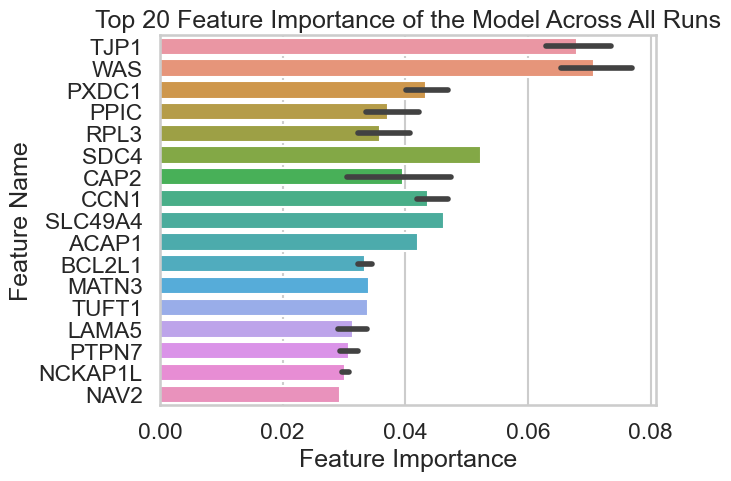

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')
sns.set_style("whitegrid")

# sort the dataframe by importance
all_feat_imp_df = all_feat_imp_df.sort_values(by='importance', ascending=False)

# visualise the top n features of the model

n = 300

sns.barplot(x=all_feat_imp_df['importance'][:n], y=all_feat_imp_df.index[:n])
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importance of the Model Across All Runs')
plt.show()